# Imports

In [1]:
# data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# machine learning
import sklearn
import xgboost
import lightgbm

# other
import gc
import json
import tqdm
import itertools
import functools
import random
from numerapi import NumerAPI

# save variables
import pickle
import joblib

# Download data

In [2]:
napi = NumerAPI()
current_round = napi.get_current_round()

# filenames = napi.list_datasets()

napi.download_dataset('v4/live.parquet', f'v4/live_{current_round}.parquet')
napi.download_dataset('v4/live_int8.parquet', f'v4/live_int8_{current_round}.parquet')

2022-07-23 19:15:40,677 INFO numerapi.utils: starting download
v4/live_326.parquet: 3.85MB [00:01, 2.51MB/s]                            
2022-07-23 19:15:43,166 INFO numerapi.utils: starting download
v4/live_int8_326.parquet: 3.86MB [00:01, 2.70MB/s]                            


# Dataframes

## Features and columns to read

In [19]:
with open('v4/features.json', 'r') as f:
    feature_metadata = json.load(f)

features_all = list(feature_metadata['feature_stats'].keys())
features_small = feature_metadata['feature_sets']['small']
features_medium = feature_metadata['feature_sets']['medium']
features_v2 = feature_metadata['feature_sets']['v2_equivalent_features']
features_v3 = feature_metadata['feature_sets']['v3_equivalent_features']
features_fncv3 = feature_metadata['feature_sets']['fncv3_features']

target = 'target_nomi_v4_20'

read_columns = ['era', 'data_type'] + features_all + [target] 

df_feature_metadata = pd.DataFrame(feature_metadata['feature_stats'])
df_feature_metadata

,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,feature_floriated_amish_sprite,feature_iconoclastic_parietal_agonist,...,feature_circumspective_daughterly_brubeck,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation
legacy_uniqueness,0.177814,0.241351,0.659092,0.234994,0.471051,0.608926,0.220884,0.671897,0.878900,0.174533,...,0.777375,0.788337,0.798391,0.777608,0.781240,0.801397,0.812955,0.824060,0.793313,0.806686
spearman_corr_w_target_nomi_20_mean,-0.000796,0.000199,-0.000619,0.001724,0.000661,-0.001529,-0.000623,-0.003439,0.000012,-0.001762,...,-0.005185,-0.005866,-0.006759,-0.005132,-0.005950,-0.001996,-0.002635,-0.003977,-0.001651,-0.002001
spearman_corr_w_target_nomi_20_sharpe,-0.078689,0.020379,-0.067669,0.127591,0.065213,-0.173158,-0.084122,-0.323518,0.001100,-0.161949,...,-0.216388,-0.252259,-0.310896,-0.219533,-0.247247,-0.094700,-0.130897,-0.205489,-0.077834,-0.095218
spearman_corr_w_target_nomi_20_reversals,0.000074,0.000082,0.000067,0.000095,0.000072,0.000058,0.000052,0.000076,0.000105,0.000086,...,0.000385,0.000365,0.000324,0.000386,0.000393,0.000324,0.000306,0.000288,0.000342,0.000313
spearman_corr_w_target_nomi_20_autocorr,-0.013665,0.110503,0.036986,0.149465,0.014508,0.023341,-0.066927,0.093560,-0.041187,-0.127240,...,0.007061,0.014354,0.006205,-0.009986,0.013370,-0.011183,-0.002933,-0.007453,-0.020823,-0.012853
spearman_corr_w_target_nomi_20_arl,3.650350,3.456954,2.916201,3.984733,3.702128,3.411765,3.262500,3.575342,3.017341,3.984733,...,3.782609,3.434211,3.650350,3.625000,3.625000,3.866667,3.755396,3.434211,3.503356,3.503356


## Train

In [4]:
df_train = pd.read_parquet('v4/train_int8.parquet', columns=read_columns)
df_train['era'] = df_train['era'].astype('int32')
df_train.info(memory_usage='deep')
df_train

<class 'pandas.core.frame.DataFrame'>
Index: 2420521 entries, n003bba8a98662e4 to nfff2bd38e397265
Columns: 1194 entries, era to target_nomi_v4_20
dtypes: float32(1), int32(1), int8(1191), object(1)
memory usage: 3.0 GB


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation,target_nomi_v4_20
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,1,train,4,2,4,4,0,0,4,4,...,0,0,0,0,4,4,4,4,4,0.25
n003bee128c2fcfc,1,train,2,4,1,3,0,3,2,3,...,3,3,3,3,2,2,2,2,2,0.75
n0048ac83aff7194,1,train,2,1,3,0,3,0,3,3,...,2,2,2,2,2,2,2,2,2,0.50
n00691bec80d3e02,1,train,4,2,2,3,0,4,1,4,...,1,1,1,1,3,2,2,3,3,0.75
n00b8720a2fdc4f2,1,train,4,3,4,4,0,0,4,2,...,4,4,3,3,2,2,2,2,3,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,574,train,0,1,0,1,4,4,3,2,...,2,2,2,2,2,3,3,1,2,0.75
nffd71b7f6a128df,574,train,0,1,0,4,2,4,0,2,...,1,1,0,0,1,1,1,1,1,0.00
nffde3b371d67394,574,train,1,1,2,1,3,3,3,1,...,2,2,2,1,1,1,1,1,1,0.25


## Validation + Test

In [5]:
df_validation = pd.read_parquet('v4/validation_int8.parquet', columns=read_columns)
df_validation['era'] = df_validation['era'].astype('int32')
df_validation.info(memory_usage='deep')
df_validation

<class 'pandas.core.frame.DataFrame'>
Index: 2272051 entries, n000101811a8a843 to nffe89a4ca372c7a
Columns: 1194 entries, era to target_nomi_v4_20
dtypes: float32(1), int32(1), int8(1191), object(1)
memory usage: 2.8 GB


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation,target_nomi_v4_20
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,575,validation,2,0,4,0,3,0,4,1,...,4,4,4,4,3,3,4,4,3,0.50
n001e1318d5072ac,575,validation,1,4,2,2,1,3,3,0,...,4,3,4,4,2,2,2,2,1,0.00
n002a9c5ab785cbb,575,validation,1,2,2,3,1,1,3,0,...,0,0,0,0,2,2,1,2,2,0.50
n002ccf6d0e8c5ad,575,validation,2,4,2,4,2,4,3,2,...,4,4,4,4,1,1,1,0,1,0.25
n0051ab821295c29,575,validation,2,0,0,1,0,4,2,1,...,1,1,1,1,4,4,3,4,4,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffb043b93d7d1f0,1019,test,4,1,4,4,2,4,3,1,...,4,4,4,4,0,0,0,0,0,NaN
nffb9dda385733cd,1019,test,0,2,3,1,2,4,2,1,...,2,1,2,2,0,0,0,0,0,NaN
nffdd70e9301e4c4,1019,test,0,2,4,1,3,0,4,4,...,2,1,1,2,2,2,1,2,2,NaN


In [6]:
df_test = df_validation.loc[df_validation['data_type'] == 'test']
df_test.info(memory_usage='deep')
df_test

<class 'pandas.core.frame.DataFrame'>
Index: 20944 entries, n002d923769ca066 to nffe89a4ca372c7a
Columns: 1194 entries, era to target_nomi_v4_20
dtypes: float32(1), int32(1), int8(1191), object(1)
memory usage: 26.6 MB


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation,target_nomi_v4_20
id,,,,,,,,,,,,,,,,,,,,,
n002d923769ca066,1016,test,4,4,4,2,4,3,4,3,...,4,4,4,4,2,2,2,2,2,NaN
n00338d3dc29117c,1016,test,3,3,2,3,4,4,3,4,...,2,2,4,3,4,4,4,4,4,NaN
n00499be7745cfef,1016,test,4,0,4,0,4,0,2,2,...,2,2,2,2,1,2,2,1,2,NaN
n007374b0fff2e70,1016,test,2,1,4,1,0,4,2,2,...,1,2,1,1,4,4,4,3,3,NaN
n0078294fa835f1f,1016,test,4,4,0,3,0,4,3,2,...,4,2,3,4,2,2,2,2,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffb043b93d7d1f0,1019,test,4,1,4,4,2,4,3,1,...,4,4,4,4,0,0,0,0,0,NaN
nffb9dda385733cd,1019,test,0,2,3,1,2,4,2,1,...,2,1,2,2,0,0,0,0,0,NaN
nffdd70e9301e4c4,1019,test,0,2,4,1,3,0,4,4,...,2,1,1,2,2,2,1,2,2,NaN


## Live

In [7]:
df_live = pd.read_parquet('v4/live_int8.parquet', columns=read_columns)
df_live.info(memory_usage='deep')
df_live

<class 'pandas.core.frame.DataFrame'>
Index: 5258 entries, n0001a9c410c4528 to nfffe975ed3a7ab3
Columns: 1194 entries, era to target_nomi_v4_20
dtypes: float64(1), int8(1191), object(2)
memory usage: 7.0 MB


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,feature_mimetic_sprawly_flue,feature_inductile_umbrian_wallah,feature_ineloquent_bihari_brougham,feature_shakespearean_alpha_constituent,feature_marxian_plated_refrigeration,feature_amative_irresponsive_flattie,feature_intermissive_coronal_reinsertion,feature_dwarfish_isochronal_amateur,feature_polyphyletic_unplumed_pandiculation,target_nomi_v4_20
id,,,,,,,,,,,,,,,,,,,,,
n0001a9c410c4528,X,live,3,2,3,2,2,3,1,4,...,4,4,4,4,1,1,0,1,0,NaN
n00321a77d2635e2,X,live,3,4,2,3,2,0,1,0,...,2,3,2,3,0,0,0,0,0,NaN
n003233b16b3010f,X,live,1,2,3,3,1,2,1,3,...,0,0,1,0,3,3,3,3,3,NaN
n0034f6b39ecadb5,X,live,3,2,4,0,0,1,1,2,...,4,4,4,3,2,2,2,3,2,NaN
n00479e7cfff7ca1,X,live,2,4,2,2,4,0,1,0,...,4,4,4,4,3,2,2,3,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffb8424ea977d43,X,live,1,4,1,2,1,3,3,2,...,0,1,1,1,3,1,2,3,3,NaN
nffe271aa63ea90d,X,live,2,2,3,2,4,2,1,3,...,2,2,2,2,4,4,3,4,4,NaN
nfff09d1bba0b9a0,X,live,4,0,2,0,0,4,4,4,...,0,0,1,1,1,2,2,3,1,NaN


# Analyse data

## Number of examples as a function of the era

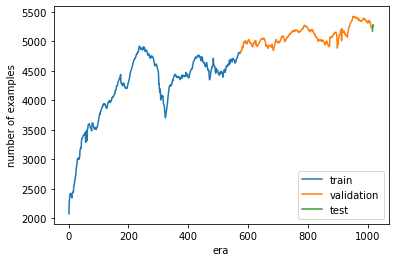

In [8]:
x_train = df_train.groupby('era').size().index.values
y_train = df_train.groupby('era').size().values
x_validation = df_validation[df_validation.data_type == 'validation'].groupby('era').size().index.values
y_validation = df_validation[df_validation.data_type == 'validation'].groupby('era').size().values
x_test = df_validation[df_validation.data_type == 'test'].groupby('era').size().index.values
y_test = df_validation[df_validation.data_type == 'test'].groupby('era').size().values

fig, ax = plt.subplots()
ax.plot(x_train, y_train, label='train')
ax.plot(x_validation, y_validation, label='validation')
ax.plot(x_test, y_test, label='test')
ax.set_xlabel('era')
ax.set_ylabel('number of examples')
ax.legend()

## Feature correlation heatmap

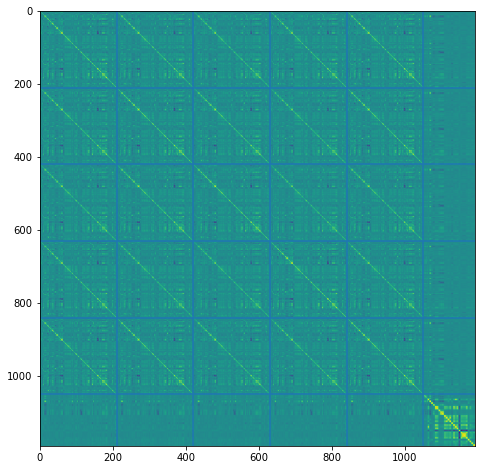

In [9]:
feature_correlations = df_train[df_train.era==1][features_all].corr()
plt.figure(figsize = (8,8))
plt.imshow(feature_correlations)
for a in [210, 420, 630, 840, 1050]:
    plt.axvline(a)
    plt.axhline(a)

feature_groups = [features_all[0:210],
                  features_all[210:420],
                  features_all[420:630],
                  features_all[840:1050],
                  features_all[1050:-1]]

## Correlation of feature with target as a function of the era

In [10]:
eras_train = df_train.era.unique()
target_correlations = np.array([np.corrcoef(df_train[df_train.era == e][[target] + features_all].T)[0, 1:] for e in eras_train])
target_correlations = pd.DataFrame(target_correlations)
target_correlations.rename(columns = dict(enumerate(features_all)), inplace = True)
target_correlations.insert(0, 'era', eras_train)

Text(0, 0.5, 'correlation with target')

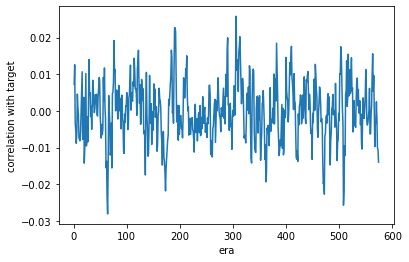

In [11]:
x = target_correlations['era']
y = target_correlations['feature_untidy_withdrawn_bargeman']

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel('era')
ax.set_ylabel('correlation with target')

# Test models

In this section we test many models without caring about hyperparameters (i.e., just use the defaults for each model). The goal is to identify which models look the most promising. Metrics to consider:

- time to train
- corr (various correlations)
- $R^2$
- score